In [1]:
import uproot
import boost_histogram as bh
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
import awkward1 as ak
import pandas as pd
import numpy as np
import seaborn as sns

def set_sns_color(*args):
    sns.palplot(sns.color_palette(*args))
    sns.set_palette(*args)

#===========================================load config file====================================================================
import sys,os
sys.path.append("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/lib")
from utils import *

import yaml
sf_particleNet_signal = {}
with open('/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/NetSF_signal_2016Legacy.yml') as f:
    sf_particleNet_signal = yaml.safe_load(f)
config = {}
with open("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/config_UL16.yml") as f:
    config = yaml.safe_load(f)
#======================================================================================================================================================
year = '2016'

In [2]:
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

In [3]:
def reshape(histo,mean,width):
    h = bh.Histogram(bh.axis.Regular(nbins, xmin, xmax))
    h.fill(np.random.normal(loc=mean, scale=width, size=int(histo.view().value.sum())))
    reshape_weight = h.view()/histo.view().value
    np.nan_to_num(reshape_weight,0)
    return reshape_weight

This is ggh


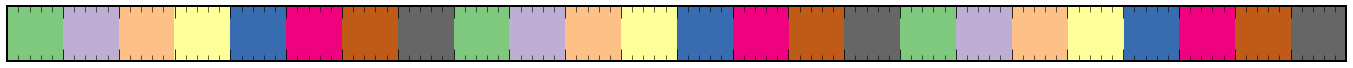

In [4]:
branchs = ['GEN_H1_mass','EventWeight','foundZ1LCandidate','foundTTCRCandidate','foundZ2JCandidate','foundZ2MergedCandidata','foundTTCRCandidate','passedfullmerged','passedfullresolved','particleNetZvsQCD','passedNassociated',
                        'massmerged','ptmerged','mass2jet',
                        'mass2l2jet', 'mass2lj',]
#samples = ['ggh125','ggh300','ggh350','ggh400','ggh450','ggh500','ggh550','ggh600','ggh700','ggh800','ggh900','ggh1000','ggh1500','ggh2500','ggh3000']
samples = ['ggh']; sam = 'ggh'
#samples = ['vbf'] ; sam = 'vbf'
#samples = ['sig'] ; sam = 'sig'

#massList = [125,300,350,400,450,500,550,600,700,800,900,1000,1500,2500,3000]
massList = []
for mass in range(500,1000,50):
    massList.append(mass)
for mass in range(1000,1600,100):
    massList.append(mass)
for mass in range(1600,3200,200):
    massList.append(mass)
# Set plot color
color_order = sns.color_palette('Accent', len(massList))
set_sns_color(color_order)
####
#sig_arr, sumWeight = extractSpecialBranch(config,year,samples,branchs)
branchs = config['var_read_lists'].append('GEN_H1_mass')
sig_arr, sumWeight = extractSpecialBranch(config,year,samples,branchs)

# GEN Raw mass Higgs

In [5]:
####Get Gen leval histograms
sig_hist_dir = {}
sig_hist = []
nbins, xmin, xmax = 400,0,4000
edge = np.linspace(xmin, xmax, nbins+1)
with uproot.recreate(f"Histos_gen{sam}_{year}.root") as f:
    for i,sample in enumerate(samples):
        print(sample)
        #temp_arr = sig_arr[sample]
        weights = np.ones_like(sig_arr[sample]['GEN_H1_mass'])
        sig_hist.append(get_hist(sig_arr[sample]['GEN_H1_mass'],weights,nbins,xmin,xmax))
        sig_hist_dir[sample] = get_hist(sig_arr[sample]['GEN_H1_mass'],weights,nbins,xmin,xmax)

        #reshape
        #re_weight = reshape(sig_hist_dir[sample],massList[i],width)
        #sig_hist_dir[sample].view().value = (sig_hist_dir[sample].view().value)*re_weight
        
        f[sample] = sig_hist_dir[sample]

ggh


[INFO] DONE


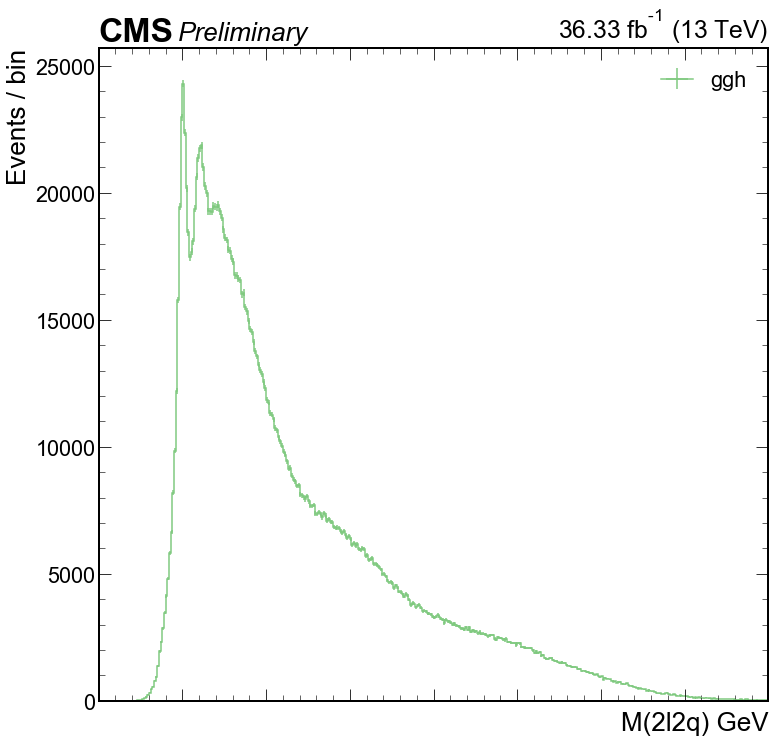

In [6]:
###plot Gen Higgs mass
f = plt.figure(figsize=(12,12))
ax = f.add_subplot()
hep.cms.label(data=True, llabel='Preliminary',year=year,rlabel=r'%s $fb^{-1}$ (13 TeV)'%config['lumi'][year], fontname='sans-serif')
ax.set_xlim(xmin, xmax); ax.set_xticklabels([]); ax.set_ylabel('Events / bin', ha='right', y=1.0)
ax.set_xlabel(r'M(2l2q) GeV', ha='right', x=1.0)
plot_hist(sig_hist,label=[ var for var in samples])
plt.legend()
plt.savefig(f'GenH_{sam}_{year}.png')
print('[INFO] DONE')


# Raw Reco Plots

This is merged
[INFO] DONE
This is resolved
[INFO] DONE
This is all
[INFO] DONE


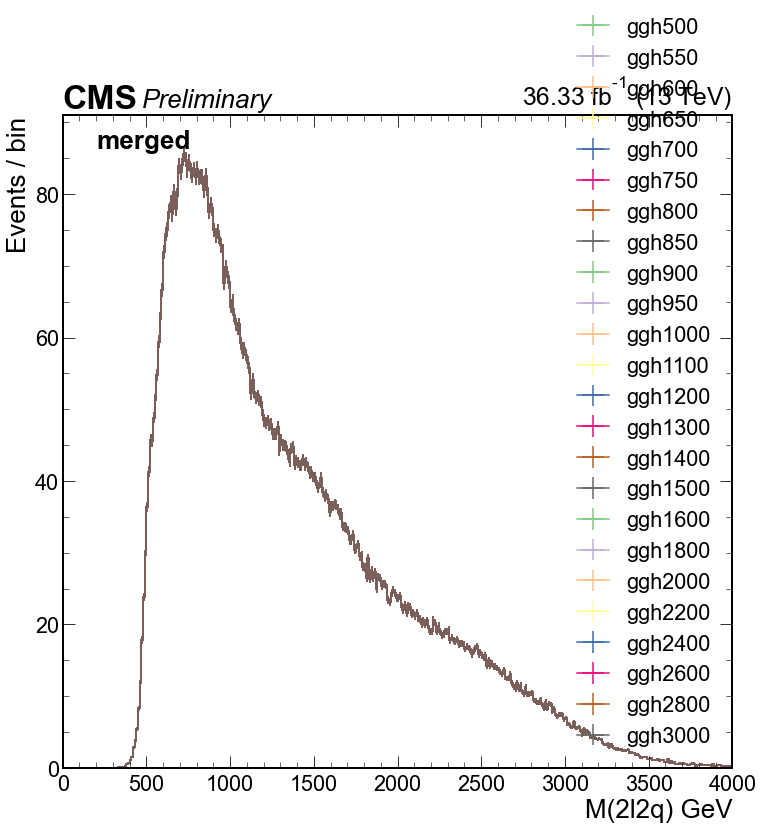

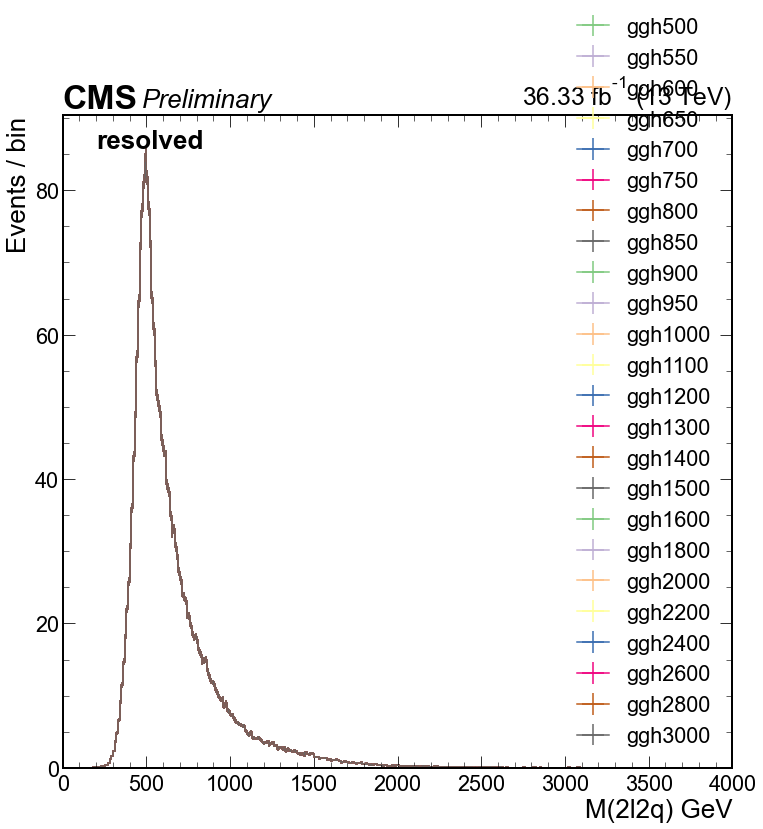

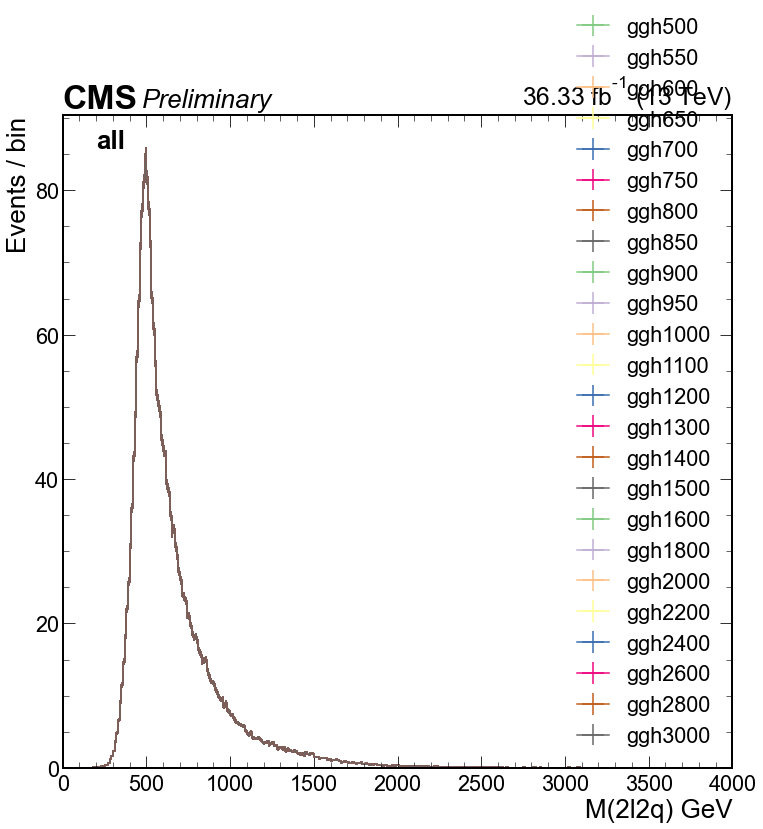

In [7]:
sig_arr_cut = {}
sig_hist_cut = {}
eff = {}
selections = {'merged':'((massmerged>70) & (massmerged<105)) & (particleNetZvsQCD>0.9) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True)',
            'resolved':'((mass2jet>70) & (mass2jet<105)) & (foundZ1LCandidate==True) & (foundZ2JCandidate==True)',
            'all': '(((massmerged>70) & (massmerged<105)) & (particleNetZvsQCD>0.9) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True)) | (((mass2jet>70) & (mass2jet<105)) & (foundZ1LCandidate==True) & (foundZ2JCandidate==True))'}
for case in selections.keys():
    print(f'This is {case}')
    if(case=='resolved'):
        massZZ = 'mass2l2jet'
    elif(case=='merged'):
        massZZ = 'mass2lj'

    sig_arr_cut[case] = {}; sig_hist_cut[case] = []; eff[case] = {}
    for i,mass in enumerate(massList):
        sample = f'{sam}{mass}'
        cut_array = ak.numexpr.evaluate(selections[case],sig_arr[sam])
        sig_arr_cut[case][sample] = sig_arr[sam][cut_array]
        weights = (sig_arr_cut[case][sample]['EventWeight']*config['lumi'][year]*config['samples_inf'][sam][1]*1000)/sumWeight[sam]
        temp_hist = get_hist(sig_arr_cut[case][sample][massZZ],weights,nbins,xmin,xmax)
        sig_hist_cut[case].append(temp_hist)
        ######calculate eff
        temp_hist_unweight = get_hist(sig_arr_cut[case][sample][massZZ],ak.ones_like(sig_arr_cut[case][sample]['EventWeight']),nbins,xmin,xmax)
        #compute eff with reshape weight applying
        #if(massList[i]>200):
        #    width = massList[i]*0.03
        #    re_weight = reshape(sig_hist_dir[sample],massList[i],width)
        #    temp_hist_unweight.view().value = (temp_hist_unweight.view().value)*re_weight
        #eff[case][sample] = temp_hist_unweight.view().value.sum()/sig_hist_dir[sample].view().value.sum()
        #print(f'eff = {eff[case][sample]} in {sample} with {case}')

    ######plot reco-plot
    f = plt.figure(figsize=(12,12))
    ax = f.add_subplot()
    hep.cms.label(data=True, llabel='Preliminary',year=year,rlabel=r'%s $fb^{-1}$ (13 TeV)'%config['lumi'][year], fontname='sans-serif')
    ax.set_xlim(xmin, xmax); ax.set_ylabel('Events / bin', ha='right', y=1.0)
    ax.set_xlabel(r'M(2l2q) GeV', ha='right', x=1.0)
    plot_hist(sig_hist_cut[case],label=[ f'{sam}{var}' for var in massList])
    ax.text(0.05, 0.95, f'{case}', transform=ax.transAxes, fontweight='bold') 
    plt.legend()
    plt.savefig(f'./plots/{year}/recoRaw_m2l2q_{sam}_{case}.png')
    print('[INFO] DONE')

    ####eff plot
    #f, ax = plt.subplots(figsize=(12, 12))
    #eff_all=[]
    #for sample in samples:
    #    eff_all.append(eff[case][sample])
    #ax.plot(massList,eff_all)


In [8]:
###signal Eff plots
plt.close()

# Re-shape reco-plots

/tmp/ipykernel_16585/1924718592.py:4: RuntimeWarning: invalid value encountered in true_divide
  reshape_weight = h.view()/histo.view().value


[INFO] DONE


/tmp/ipykernel_16585/1924718592.py:4: RuntimeWarning: invalid value encountered in true_divide
  reshape_weight = h.view()/histo.view().value


[INFO] DONE


/tmp/ipykernel_16585/1924718592.py:4: RuntimeWarning: invalid value encountered in true_divide
  reshape_weight = h.view()/histo.view().value


[INFO] DONE


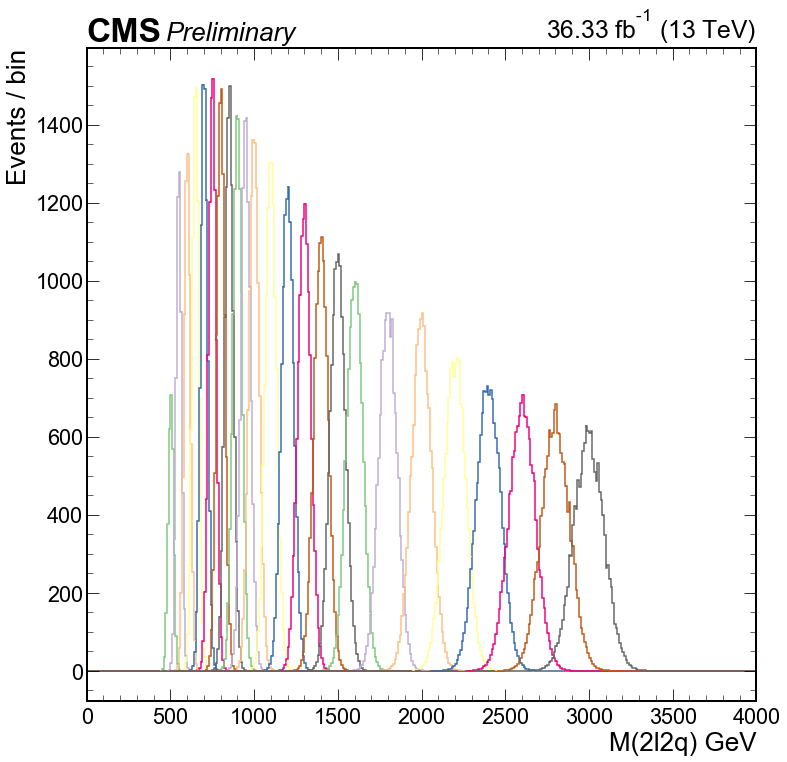

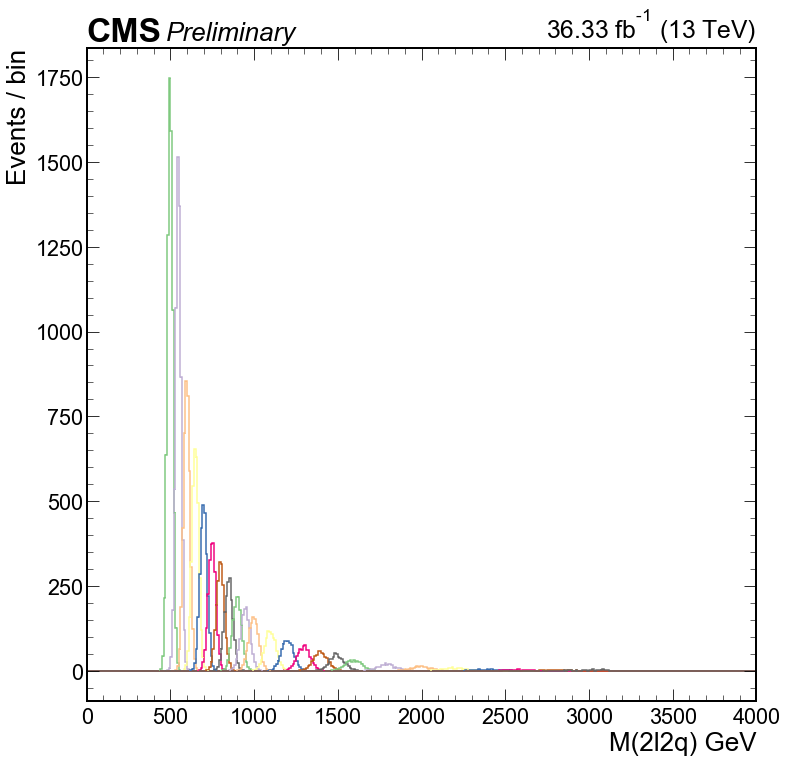

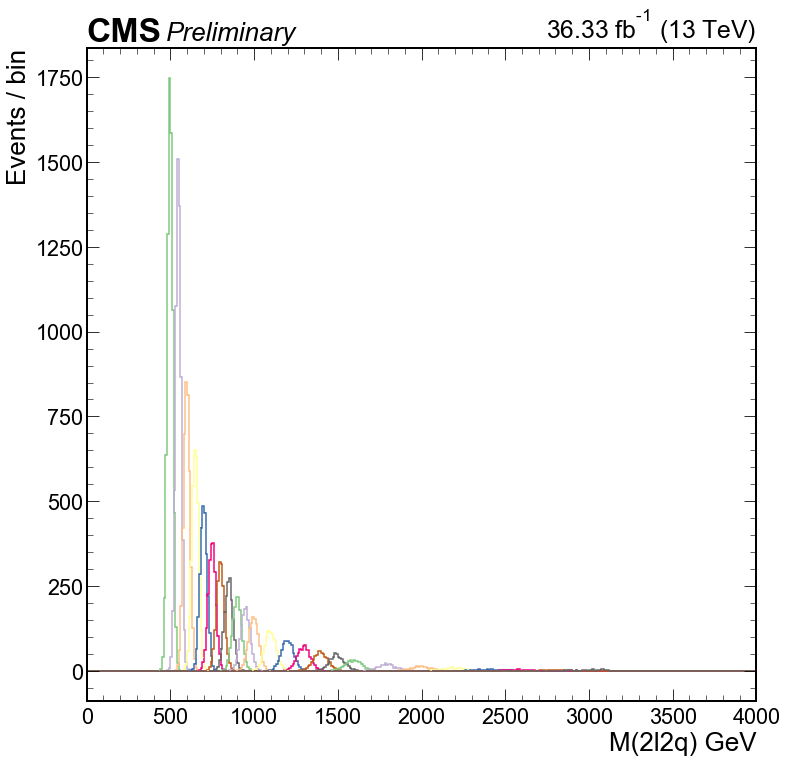

In [9]:
nSample = len(samples)
#sample = 'ggh'
sig_hist_reshape = {}
#width = 100
for case in selections.keys():
    sig_hist_reshape[case]=[]
    for i,mass in enumerate(massList):
        sig_hist_reshape[case].append(sig_hist_cut[case][i]) #sig_hist_cut = Reco_sig_with_selections
        #if(massList[i]>700): #reshape if mass lager than 700
        #    re_weight = reshape(sig_hist[i],massList[i],width) #sig_hist = GEN_sig_hist_withoutCut
        #    sig_hist_reshape[case][i].view().value = (sig_hist_reshape[case][i].view().value)*re_weight
        if(massList[i]>0): #reshape if mass lager than 700
            width = massList[i]*0.03
            re_weight = reshape(sig_hist[0],massList[i],width) #sig_hist = GEN_sig_hist_withoutCut
            sig_hist_reshape[case][i].view().value = (sig_hist_reshape[case][i].view().value)*re_weight


    ######plot reshaped reco-plot
    f = plt.figure(figsize=(12,12))
    ax = f.add_subplot()
    hep.cms.label(data=True, llabel='Preliminary',year=year,rlabel=r'%s $fb^{-1}$ (13 TeV)'%config['lumi'][year], fontname='sans-serif')
    ax.set_xlim(xmin, xmax); ax.set_ylabel('Events / bin', ha='right', y=1.0)
    ax.set_xlabel(r'M(2l2q) GeV', ha='right', x=1.0)
    plot_hist(sig_hist_reshape[case],label=[ f'{sam}{var}' for var in massList])
    #ax.set_ylim(0, 3000)
    #plt.legend()
    plt.savefig(f'./plots/{year}/recoReshaped_m2l2q_{sam}_{case}.png')
    print('[INFO] DONE')

In [10]:
plt.close()

In [11]:
with uproot.recreate(f'Histos_{sam}_{year}.root') as f:
    for case in selections.keys():
        for i,mass in enumerate(massList):
            sample = f'{sam}{mass}'
            f[f'{sample}_{case}'] = sig_hist_reshape[case][i]
    

# Get Eff for different catgory

In [12]:
#regions = ['CR','SR']
#samples = ['ggh500','ggh600','ggh700','ggh800','ggh900','ggh1000','ggh1500','ggh2500','ggh3000']
region = "SR"
tags = ['btag','untag','vbftag']
#channels = ['isEE','isMuMu','2lep']
channels = ['isEE','isMuMu']
cases = ['merged','resolved']
if(sam=='ggh'):
    pro_str = 'spin0_ggH'
elif(sam=='vbf'):
    pro_str = 'spin0_VBF'
chanName = {'isEE':'eeqq','isMuMu':'mumuqq','2lep':'llqq'}
caseName = {'merged':"Merged",'resolved':"Resolved"}
tagName = {'btag':'b-tagged','untag':'untagged','vbftag':'vbf-tagged'}


In [13]:
from array import array

In [14]:
sig_arr_cut = {}
sig_hist_cut = {}
eff = {}
eff_GraphY = {}; eff_GraphYerr = array('f',[])
eff_graph = {}
#samples = ['ggh500']; channels = ['2lep']
for channel in channels:
    sig_arr_cut[channel] = {}; sig_hist_cut[channel]={}; eff[channel] = {}; eff_GraphY[channel] = {}; eff_graph[channel] = {}
    for case in cases:
        if case=='merged':
            massZZ = 'mass2lj'
        elif case=='resolved':
            massZZ = 'mass2l2jet'
        sig_arr_cut[channel][case] = {}; sig_hist_cut[channel][case] = {}; eff[channel][case] = {}; eff_GraphY[channel][case] = {}; eff_graph[channel][case]={}
        for tag in tags:
            sig_arr_cut[channel][case][tag] = {}; sig_hist_cut[channel][case][tag] = []; eff[channel][case][tag] = {}; eff_GraphY[channel][case][tag] = array('f',[]); eff_graph[channel][case][tag]=None
            selection = config['cut'][region][channel][case][tag]
            print(f"[INFO] cut selection = {selection}")
            for i,mass in enumerate(massList):
                sample = f'{sam}{mass}'
                #print(f'[INFO] This is {channel} {case} {tag} in {sample}')
                #selection = config['cut'][region][channel][case][tag]
                cut_array = ak.numexpr.evaluate(selection,sig_arr[sam])
                sig_arr_cut[channel][case][tag][sample] = sig_arr[sam][cut_array]
                weights = (sig_arr_cut[channel][case][tag][sample]['EventWeight']*config['lumi'][year]*config['samples_inf']['ggh'][1]*1000)/sumWeight[sam]
                temp_hist = get_hist(sig_arr_cut[channel][case][tag][sample][massZZ],weights,nbins,xmin,xmax)
                sig_hist_cut[channel][case][tag].append(temp_hist)
                ######calculate eff
                temp_hist_unweight = get_hist(sig_arr_cut[channel][case][tag][sample][massZZ],ak.ones_like(sig_arr_cut[channel][case][tag][sample]['EventWeight']),nbins,xmin,xmax)
                #print(f'[INFO] sum of events after applying selections in {channel} {case} {tag} {sample} = {temp_hist_unweight.view().value.sum()}')
                #print(f'[INFO] sum of events after applying selections and weight in {channel} {case} {tag} {sample} = {temp_hist.view().value.sum()}')
                #print(f'[INFO] sum of events in GEN level in {sample} = {sig_hist_dir[sample].view().value.sum()}')
                #print(f'[INFO] ')
                if(massList[i]>0): #reshape if mass lager than 700
                    width = massList[i]*0.03
                    re_weight = reshape(sig_hist[0],mass,width) #sig_hist = GEN_sig_hist_withoutCut
                    temp_hist_unweight.view().value = (temp_hist_unweight.view().value)*re_weight
                reco_number = temp_hist_unweight.view().value.sum()
                gen_number = sig_hist_dir[sam].view().value.sum()
                eff[channel][case][tag][sample] = (temp_hist_unweight.view().value.sum())/(sig_hist_dir[sam].view().value.sum())
                eff[channel][case][tag][sample] = reco_number/gen_number
                if(eff[channel][case][tag][sample]==np.inf):
                    eff[channel][case][tag][sample]=0.0
                eff_GraphY[channel][case][tag].append(eff[channel][case][tag][sample]); eff_GraphYerr.append(0.0)
                print(f'eff = {eff[channel][case][tag][sample]} in {channel} {case} {tag} in {sample}')

[INFO] cut selection = ((massmerged>70) & (massmerged<105)) & (particleNetZvsQCD>0.9) & (particleNetZbbvslight>0.9) & (KD_JVBF<0.5) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True) & (isEE==True)


/tmp/ipykernel_16585/1924718592.py:4: RuntimeWarning: invalid value encountered in true_divide
  reshape_weight = h.view()/histo.view().value


eff = 0.016888264904859698 in isEE merged btag in ggh500
eff = 0.02896098637447012 in isEE merged btag in ggh550
eff = 0.03127455687192167 in isEE merged btag in ggh600
eff = 0.03664572207464977 in isEE merged btag in ggh650
eff = 0.039560399063140586 in isEE merged btag in ggh700
eff = 0.04180516631401052 in isEE merged btag in ggh750
eff = 0.043107574622686474 in isEE merged btag in ggh800
eff = 0.044571037498726825 in isEE merged btag in ggh850
eff = 0.04595889149723792 in isEE merged btag in ggh900
eff = 0.04683152394937308 in isEE merged btag in ggh950
eff = 0.04687180190234143 in isEE merged btag in ggh1000
eff = 0.047583687459238806 in isEE merged btag in ggh1100
eff = 0.049598364136544545 in isEE merged btag in ggh1200
eff = 0.049145190672988615 in isEE merged btag in ggh1300
eff = 0.049762384571755025 in isEE merged btag in ggh1400
eff = 0.0504719707416713 in isEE merged btag in ggh1500
eff = 0.04878193482058576 in isEE merged btag in ggh1600
eff = 0.04947782897821369 in isEE 

In [15]:
from ROOT import *

Welcome to JupyROOT 6.26/00


In [16]:
#Set resolved fit funtion
gInterpreter.Declare("""
    Double_t resolved_fit(Double_t *xx, Double_t *par)
    {
        Float_t x =xx[0];
        Double_t f = par[8]*TMath::Gaus(x,par[4], par[10]) + TMath::ATan((x-par[9])/par[11])*par[0]*ROOT::Math::crystalball_function(x, par[1], par[2], par[3], par[4])+par[5]*TMath::Erf((x-par[6])/par[7]);
        return f;
    }
""")

gInterpreter.Declare("""
    Double_t merged_fit(Double_t *xx, Double_t *par)
    {
       Double_t temp = 1700;  //quadratic spline
       Double_t x =xx[0], y=(x-temp)/1000.;
       Double_t f;

       if(x<=temp) f = par[0]*TMath::Erf( (x-par[1])/par[2] ) + (par[3] + par[4]*TMath::ATan((x-par[5])/par[6]));
       else {f = merged_fit(&temp, par) + par[7]*y+par[8]*y*y; }
       return f;
    }
""")



True

In [17]:
#polyFunctot_resolved = TF1("polyFunctot_resolved",resolved_fit, 500., 3000, 12)
#polyFunctot_resolved.SetRange(500,0,3000,1)
#polyFunctot_resolved = TF1("polyFunctot_resolved",resolved_fit_new1, 500., 3000,12)
#polyFunctot_resolved.SetParameters(.1, -1.5, 2, 200, 500, .04, 1000, 100, .1, 800, 200)
#polyFunctot_resolved.SetParLimits(0,0,.25)
#polyFunctot_resolved.SetParLimits(1,-2,-1)
#polyFunctot_resolved.SetParLimits(2,1.3,2.5)
#polyFunctot_resolved.SetParLimits(3,50,300)
#polyFunctot_resolved.SetParLimits(4,400,700)
#polyFunctot_resolved.SetParLimits(6,1000,1500)
#polyFunctot_resolved.SetParLimits(7,100,500)
#polyFunctot_resolved.SetParLimits(8,-.05,.05)
#polyFunctot_resolved.SetParLimits(9,100,600)
#polyFunctot_resolved.SetParLimits(10,200,800)
#polyFunctot_resolved.SetParLimits(11,100,1000)
#polyFunctot_resolved.SetParLimits(10,250,1000)
#polyFunctot_resolved.SetParLimits(11,250,1000)
#polyFunctot_resolved_new = TF1("polyFunctot_resolved",resolved_fit_new2, 500., 3000, 12)

#polyFunctot_resolved.SetParLimits(1,-2,-0.5)
#polyFunctot_resolved.SetParLimits(2,1.0,2.5)
#polyFunctot_resolved.SetParLimits(6,800,1500)
#polyFunctot_resolved.SetParLimits(7,100,700)
#

polyFunctot_merged= TF1("polyFunctot_merged",merged_fit, 500., 3000, 9)
#polyFunctot_merged= TF1("polyFunctot_merged",merged_fit, 200., 3000)
polyFunctot_merged.SetParameters(0.055533, 696.978882, 201.791214, 0.074554, 0.013758, 1489.137451, 272.321777, 0.01, -0.01)
polyFunctot_merged.SetParLimits(0,.003,.2)
polyFunctot_merged.SetParLimits(1,500,1100)
polyFunctot_merged.SetParLimits(2,150,500)
polyFunctot_merged.SetParLimits(3,0,1)
polyFunctot_merged.SetParLimits(4,.003,.2)
polyFunctot_merged.SetParLimits(5,500,1100)
polyFunctot_merged.SetParLimits(6,150,500)
polyFunctot_merged.SetParLimits(7,-.02,.02)
polyFunctot_merged.SetParLimits(8,-.02,.02)

In [21]:
polyFunctot_resolved = TF1("polyFunctot_resolved",resolved_fit, 500., 3000, 12)
polyFunctot_resolved.SetParameters(.1, -1.5, 2, 200, 500, .04, 1000, 100, .1, 800, 200)
#create TGaph for store and fro Fit 
MultiGraph = {}
eff_graph = {}
eff_graphX = array('f',massList); eff_graphXerr = array('f',[])
for i in eff_graphX:
    eff_graphXerr.append(0)
#colorList = [ROOT.EColor.kGreen,ROOT.EColor.kYellow+2,ROOT.EColor.kRed,ROOT.EColor.kMagenta,ROOT.EColor.kBlue,ROOT.EColor.kCyan]
colorList = [kGreen,kYellow+2,kRed,kMagenta,kBlue,kCyan]
#fit_fun = ROOT.TF1('pol11','[0]+[1]*x+[2]*x^2+[3]*x^3+[4]*x^4+[5]*x^5+[6]*x^6+[7]*x^7+[8]*x^8+[9]*x^9+[10]*x^10+[11]*x^11',0,3500)
#fit_fun = TF1('pol11','([0]+[1]*erf((x-[2])/[3]))*([4]+[5]*x+[6]*x*x+[7]*x*x*x)+([8]*gaus(x))',110., 3000)
##fit_fun.SetParameters(0,0,1000,10,0,0,0,0,0,0,0)
#fit_fun.SetParameters(-4.42749e+00,4.61212e+0,-6.21611e+01,1.13168e+02,2.14321e+00,1.04083e-03,4.89570e-07, 0.03, 200, 100)
#fit_fun.SetParLimits(7,0,0.2)
#fit_fun.SetParLimits(8,160,210)
#fit_fun.SetParLimits(9,10,70)
#fit_fun.SetParameters(100,0,0,0,0,0,0,0,0,0,0)
if sam=='ggh':
    outfile = TFile(f"./2l2q_Efficiency_spin0_ggH_{year}.root",'recreate'); outfile.cd()
elif sam=='vbf':
    outfile = TFile(f"./2l2q_Efficiency_spin0_VBF_{year}.root",'recreate'); outfile.cd()
for channel in channels:
    c = TCanvas('c','c',1300,800)
    eff_graph[channel] = {}; MultiGraph[channel] = TMultiGraph()
    leg = TLegend( .64, .55, .97, .75 )
    i = 0
    for case in cases:
        eff_graph[channel][case] = {}
        for tag in tags:
            #print(f'[INFO] this eff in  {channel}_{case}_{tag} = {eff_GraphY[channel][case][tag]}')
            eff_graph[channel][case][tag] = TGraphErrors(len(eff_graphX),eff_graphX,eff_GraphY[channel][case][tag],eff_graphXerr,eff_GraphYerr)
            MultiGraph[channel].Add(eff_graph[channel][case][tag],'PL')
            eff_graph[channel][case][tag].SetLineColor(colorList[i]) ; i +=1
            #eff_graph[channel][case][tag].SetLineStyle(0)
            eff_graph[channel][case][tag].SetMarkerSize(1)
            eff_graph[channel][case][tag].SetMarkerStyle(20)
            leg.AddEntry(eff_graph[channel][case][tag],f'{channel}_{case}_{tag}',"l")
            #================initilizeParm====================
            polyFunctot_resolved.SetParLimits(0,0,.25)
            polyFunctot_resolved.SetParLimits(1,-2,-1)
            polyFunctot_resolved.SetParLimits(2,1.3,2.5)
            polyFunctot_resolved.SetParLimits(3,50,300)
            polyFunctot_resolved.SetParLimits(4,100,200)
            polyFunctot_resolved.SetParLimits(6,1000,1500)
            polyFunctot_resolved.SetParLimits(7,100,500)
            polyFunctot_resolved.SetParLimits(8,-.05,.05)
            polyFunctot_resolved.SetParLimits(9,100,600)
            polyFunctot_resolved.SetParLimits(10,200,800)
            polyFunctot_resolved.SetParLimits(11,100,1000)
            #=================ResetParm==========================
            if(sam=='vbf' and channel == 'isEE' and case=='resolved' and tag=='btag'):
                if(year=='2016'):
                    print('[INFO] fix parm for vbf_eeqq_resolved_btag in 2016')
                    polyFunctot_resolved.SetParLimits(1,-2,-0.5)
                    polyFunctot_resolved.SetParLimits(2,1.3,3.0)
                    polyFunctot_resolved.SetParLimits(6,1000,1500)
                    polyFunctot_resolved.SetParLimits(7,100,600)
                elif(year=='2017' or year=='2018'):
                    print('[INFO] fix parm for vbf_eeqq_resolved_btag in 2017 and 2018')
                    polyFunctot_resolved.SetParLimits(7,100,800)
            elif(sam=='vbf' and channel == 'isEE' and case=='resolved' and tag=='vbftag'):
                print('[INFO] fix parm for vbf_eeqq_resolved_vbftag')
                polyFunctot_resolved.SetParLimits(1,-2,-0.5)
                polyFunctot_resolved.SetParLimits(2,1.0,2.5)
                polyFunctot_resolved.SetParLimits(6,350,1200)
                polyFunctot_resolved.SetParLimits(7,0,500)
                polyFunctot_resolved.SetParLimits(10,50,500)
            elif(sam=='vbf' and channel == 'isMuMu' and case=='resolved' and tag=='btag'):
                print('[INFO] fix parm for vbf_mumuqq_resolved_btag')
                polyFunctot_resolved.SetParLimits(1,-2,-0.5)
                polyFunctot_resolved.SetParLimits(2,1.3,3.0)
                polyFunctot_resolved.SetParLimits(6,1000,1500)
                polyFunctot_resolved.SetParLimits(7,100,600)
            elif(sam=='ggh' and channel == 'isMuMu' and case=='resolved' and tag=='vbftag'):
                if(year=='2018'):
                    print('[INFO] fix parm for vbf_mumuqq_resolved_vbftag in 2018')
                    polyFunctot_resolved.SetParLimits(7,100,800)
                
            #fit
            if(case=='merged'):
                #eff_graph[channel][case][tag].Fit(polyFunctot_merged,"qw")
                eff_graph[channel][case][tag].Fit('pol8',"qwm","",500.0,3000.0)
            else:
                eff_graph[channel][case][tag].Fit(polyFunctot_resolved,"qwm","",500.0, 3000.0)
            eff_graph[channel][case][tag].Write(f'{pro_str}_{chanName[channel]}_{caseName[case]}_{tagName[tag]}')


    MultiGraph[channel].Draw("A pmc plc")
    MultiGraph[channel].GetXaxis().SetTitle('M_2l2q [GeV]')
    MultiGraph[channel].GetYaxis().SetTitle("eff*acc"); MultiGraph[channel].GetYaxis().SetTitleSize(0.025)
    MultiGraph[channel].SetTitle(f'Channel {channel}')
    leg.Draw()
    c.SetTitle(f'Channel {channel}')
    c.SaveAs(f'./plots/{year}/eff_{sam}_{channel}.png')
    c.Close()

outfile.Write(); outfile.Close()



Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Info in <TCanvas::Print>: png file ./plots/2016/eff_ggh_isEE.png has been created
Info in <TCanvas::Print>: png file ./plots/2016/eff_ggh_isMuMu.png has been created


In [22]:
c.Close()